In [ ]:
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from matplotlib import pyplot as plt

In [ ]:
# Accuracy 계산
def get_acc(model, X, y):
    y_pred = model.predict(X)
    return sum(y_pred == y) / len(y)

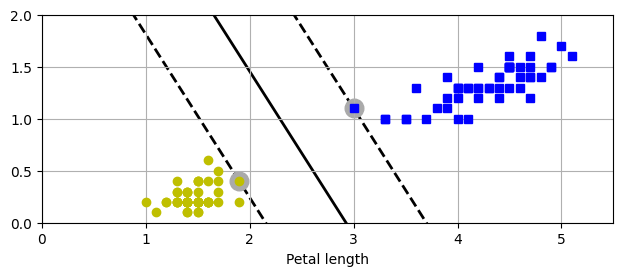

In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn import datasets

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # 결정 경계에서, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0] / w[1] * x0 - b / w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    svs = svm_clf.support_vectors_

    plt.plot(x0, decision_boundary, "k-", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_up, "k--", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_down, "k--", linewidth=2, zorder=-2)
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#AAA',
                zorder=-1)

# 학습용 데이터 - 아이리스 꽃 데이터를 사용한다.
iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]


# SVM 분류 모델 실습 - 선형 SVM classfier 모델 사용
svm_clf = SVC(kernel="linear", C=10**9)
svm_clf.fit(X, y)

fig, axes = plt.subplots(figsize=(10, 2.7), sharey=True)

plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length")
plt.axis([0, 5.5, 0, 2])
plt.gca().set_aspect("equal")
plt.grid()

plt.show()

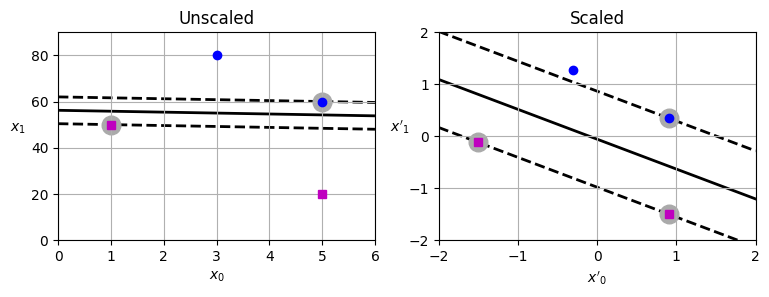

In [ ]:
# 스케일링에 의한 성능 - 데이터 간 거리를 기반으로 분류하기 때문에, 스케일링의 영향을 매우 많이 받는다.
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])

svm_clf = SVC(kernel="linear", C=100).fit(Xs, ys)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf_scaled = SVC(kernel="linear", C=100).fit(X_scaled, ys)

plt.figure(figsize=(9, 2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$")
plt.ylabel("$x_1$    ", rotation=0)
plt.title("Unscaled")
plt.axis([0, 6, 0, 90])
plt.grid()

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf_scaled, -2, 2)
plt.xlabel("$x'_0$")
plt.ylabel("$x'_1$  ", rotation=0)
plt.title("Scaled")
plt.axis([-2, 2, -2, 2])
plt.grid()

plt.show()
# 스케일을 통해 결정 경계의 기울기가 더 상세(?)해진 것을 확인할 수 있다.

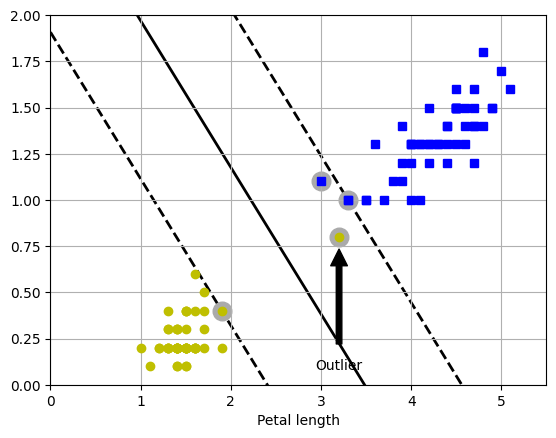

In [ ]:
# 이상치에 대한 하드 마진과 소프트 마진 차이
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

# C값은 분류가 틀렸을 때 주는 패널티이기 때문에, 쎄게 주느냐 약하게 주느냐에 따라 hard/soft과 같은 영향을 줄 수 있다.
# svm_clf2 = SVC(kernel="linear", C=10**9) # hard
svm_clf2 = SVC(kernel="linear", C=2) # soft
svm_clf2.fit(Xo2, yo2)

plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length")
plt.annotate(
    "Outlier",
    xy=(X_outliers[1][0], X_outliers[1][1]),
    xytext=(3.2, 0.08),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
)
plt.axis([0, 5.5, 0, 2])
plt.grid()

plt.show()

In [ ]:
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

def plot_predictions(clf, axes, sc=None, pf=None):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]

    if pf:
        X = pf.transform(X)
    if sc:
        X =sc.transform(X)

    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

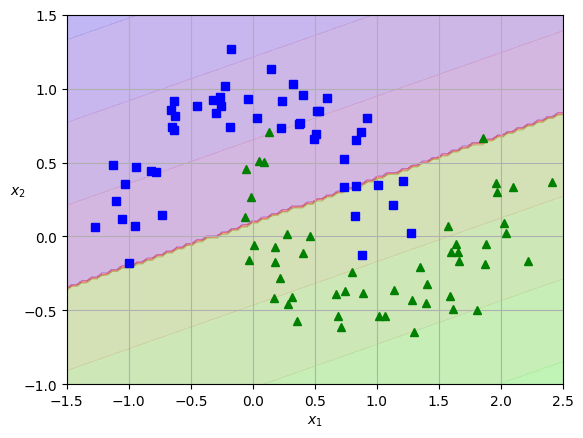

In [ ]:
# 비선형 분류

from sklearn.datasets import make_moons # 선형 분리가 불가능한 데이터셋을 만들어주는 함수

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

lsvm_clf = LinearSVC(C=10, max_iter=10_000, random_state=42)

sc = StandardScaler()
sc_X = sc.fit_transform(X)
lsvm_clf.fit(sc_X, y)

plot_predictions(lsvm_clf, [-1.5, 2.5, -1, 1.5], sc)
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()
# 비선형 분류 데이터를 선형 모델로 구분을 못하는 것을 확인할 수 있다.

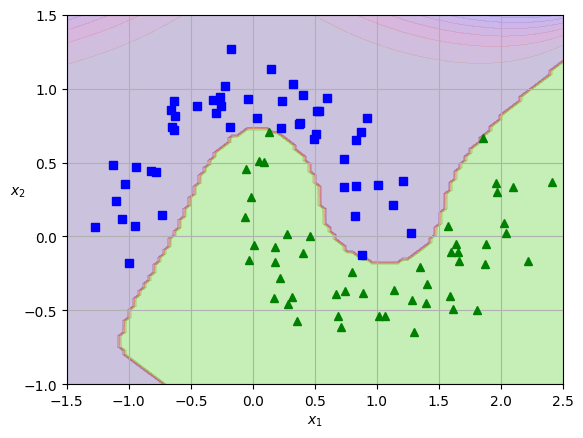

In [ ]:
# 비선형 분류 (PolynomialFeatures)

from sklearn.datasets import make_moons # 선형 분리가 불가능한 데이터셋을 만들어주는 함수

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

pf = PolynomialFeatures(degree=10)
sc = StandardScaler()
lsvm_clf = LinearSVC(C=10, max_iter=10_000, random_state=42)

pf_x = pf.fit_transform(X)
sc_X = sc.fit_transform(pf_x)
lsvm_clf.fit(sc_X, y)

plot_predictions(lsvm_clf, [-1.5, 2.5, -1, 1.5], sc, pf)
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()
# 다항 회귀를 통한 분류로 분류가 되는 것 확인. -> 비선형으로 해결이 가능하긴 하다는 것을 확인한 것

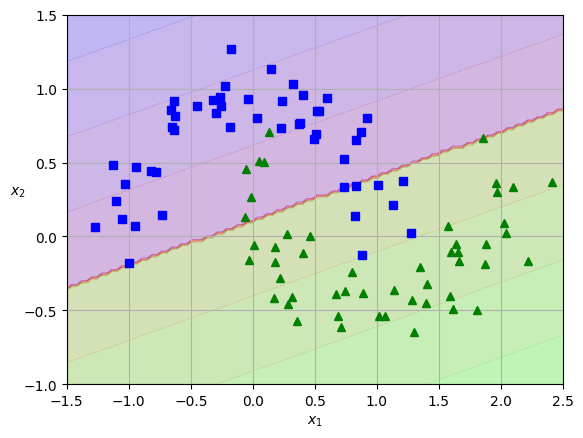

In [ ]:
# 커널별 실습 (linear)
linear_kernel_svm_clf = SVC(kernel='linear', C=5)

sc = StandardScaler()
sc_X = sc.fit_transform(X)

linear_kernel_svm_clf.fit(sc_X, y)

plot_predictions(linear_kernel_svm_clf, [-1.5, 2.5, -1, 1.5], sc)
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

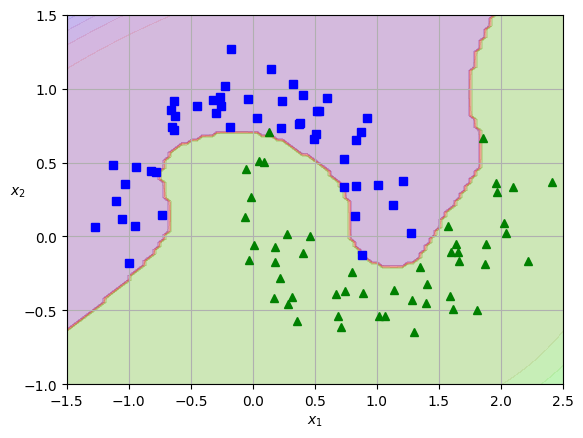

In [ ]:
# 커널별 실습 (poly)
poly_kernel_svm_clf = SVC(kernel='poly', degree=10, coef0=0.5, C=5)

sc = StandardScaler()
sc_X = sc.fit_transform(X)

poly_kernel_svm_clf.fit(sc_X, y)

plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5], sc)
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

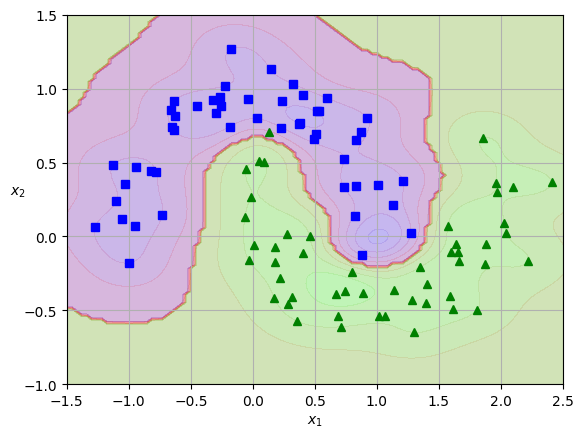

In [ ]:
# 커널별 실습 (rbf)
rbf_kernel_svm_clf = SVC(kernel='rbf',gamma=5, C=5) # gamma = 가우시안 분포의 영향을 얼마나 줄 것인가

sc = StandardScaler()
sc_X = sc.fit_transform(X)

rbf_kernel_svm_clf.fit(sc_X, y)

plot_predictions(rbf_kernel_svm_clf, [-1.5, 2.5, -1, 1.5], sc)
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

In [ ]:
# satimage 데이터를 이용한 실습
from google.colab import drive
from sklearn.model_selection import train_test_split
drive.mount('/content/drive')
stimage_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/2학기/2교시-기계학습 기초/11주차 앙상블/satimage.csv')
stimage_data.head(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,A1,B1,C1,D1,A2,B2,C2,D2,A3,B3,...,D7,A8,B8,C8,D8,A9,B9,C9,D9,class
0,0.117596,1.241362,1.184036,0.815302,-0.158561,1.256483,1.193546,0.818486,-0.141965,0.879481,...,0.807707,-0.069968,1.219160,1.250463,0.597678,-0.054291,1.233342,1.262255,0.603258,1
1,-1.205362,-1.249654,-0.077532,0.444886,-0.895959,-0.447579,-0.786760,-0.554203,-0.364672,0.092157,...,-0.192752,-0.736996,-0.969292,-0.844805,-0.400030,-0.725852,-0.344432,-0.594534,-0.183967,5
2,0.779075,0.148811,0.042617,-0.243030,0.800057,0.164136,0.053370,-0.448612,0.154978,-0.345245,...,-0.877277,0.671174,-0.006373,-0.425752,-0.662584,0.691889,0.356801,-0.175259,-0.236449,7
3,1.146564,0.585831,0.342991,0.021553,0.947536,0.601074,0.353416,0.026550,1.788164,1.010702,...,0.281150,1.412317,1.044084,0.532085,0.282612,1.438068,1.058033,0.842981,0.130923,3
4,-0.764376,-1.162250,-0.137607,0.180303,-0.969698,-1.146681,-0.126658,0.184937,-0.735851,-1.132569,...,-0.192752,-0.885225,-1.231906,-0.784941,-0.347519,-0.875088,-1.220973,-0.774223,-0.551339,5


In [ ]:
y = stimage_data['class']
stimage_data.drop(['class'], axis=1, inplace=True)
X = stimage_data.values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
svm_clf = SVC(kernel='rbf',gamma=5, C=5) # gamma = 가우시안 분포의 영향을 얼마나 줄 것인가

sc = StandardScaler()
sc_X = sc.fit_transform(X)
svm_clf.fit(sc_X, y)

print(f'train acc: {get_acc(svm_clf, X_train, y_train)} / test acc: {get_acc(svm_clf, X_test, y_test)}')

train acc: 1.0 / test acc: 1.0


In [ ]:
svm_clf = SVC(kernel='rbf',gamma=5, C=5) # gamma = 가우시안 분포의 영향을 얼마나 줄 것인가

svm_clf.fit(X, y)

print(f'train acc: {get_acc(svm_clf, X_train, y_train)} / test acc: {get_acc(svm_clf, X_test, y_test)}')

train acc: 1.0 / test acc: 1.0


In [ ]:
svm_clf = SVC(kernel='poly',degree=10, coef0=0.5, C=5)

sc = StandardScaler()
sc_X = sc.fit_transform(X)
svm_clf.fit(sc_X, y)

print(f'train acc: {get_acc(svm_clf, X_train, y_train)} / test acc: {get_acc(svm_clf, X_test, y_test)}')

train acc: 0.9479469099958523 / test acc: 0.9601990049751243
